# Denoising Images with Autoencoders based on Feed-Forward Neural Networks

Version 1.1

(C) 2020 - Umberto Michelucci, Michela Sperti

This notebook is part of the book _Applied Deep Learning: a case based approach, **2nd edition**_ from APRESS by [U. Michelucci](mailto:umberto.michelucci@toelt.ai) and [M. Sperti](mailto:michela.sperti@toelt.ai).

The purpose of this notebook is to give an example of Autoencoders implemented with feed-forward neural networks applied to denoise images. The example dataset is taken from the real world.

## Notebook Learning Goals

At the end of the notebook you will be able to implement yourself an autoencoder to be applied in a denoising problem (with feed-forward neural networks). It is very instructive to compare this notebook with *Denoising_autoencoders_with_CNN.ipynb* since they both solve the same problem, but with a different autoencoder architecture.

## Libraries and Dataset Import

This section contains the necessary libraries (such as tensorflow or pandas) you need to import to run the notebook.

In [1]:
# general libraries
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from random import *

# tensorflow libraries
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

### MNIST Dataset

For this notebook we will use the [MNIST Dataset](http://yann.lecun.com/exdb/mnist/). You can check the dataset with the previous link. It can be easily imported using Keras. Below you can see how easy it is to download it using [```tensorflow.keras.datasets```](https://www.tensorflow.org/api_docs/python/tf/keras/datasets).

In [2]:
# Load MNIST dataset
(input_train, target_train), (input_test, target_test) = mnist.load_data()

In [3]:
# Reshape data based on channels first / channels last strategy.
# This is dependent on whether you use TF, Theano or CNTK as backend.
# Source: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

img_width, img_height = 28, 28

if K.image_data_format() == 'channels_first':
    input_train = input_train.reshape(input_train.shape[0], 1, img_width, img_height)
    input_test = input_test.reshape(input_test.shape[0], 1, img_width, img_height)
    input_shape = (1, img_width, img_height)
else:
    input_train = input_train.reshape(input_train.shape[0], img_width, img_height, 1)
    input_test = input_test.reshape(input_test.shape[0], img_width, img_height, 1)
    input_shape = (img_width, img_height, 1)

As usual we will do the typical normalisation of the datasets as you can see below. At this point in the book you should be able to understand the code below easily.

In [4]:
# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

input_train = input_train.reshape((len(input_train), np.prod(input_train.shape[1:])))
input_test = input_test.reshape((len(input_test), np.prod(input_test.shape[1:])))

Let's plot an image example for each possible class (i.e. digits from 0 to 9).

In [5]:
def get_random_element_with_label (data, lbls, lbl):
  """Returns one numpy array (one column) with an example of a choosen label."""
  
  tmp = lbls == lbl
  subset = data[tmp.flatten(), :]
  return subset[randint(0, subset.shape[0]), :]

In [6]:
# The following line is needed to reshape the training dataset 
# (to plot some image examples)
input_example = input_train.reshape(60000, 784)

In [7]:
# The following code create a numpy array where in column 0 you will find 
# an example of label 0, in column 1 of label 1 and so on.
labels_overview = np.empty([784, 10])
for i in range (0, 10):
    col = get_random_element_with_label(input_example, target_train, i)
    labels_overview[:,i] = col

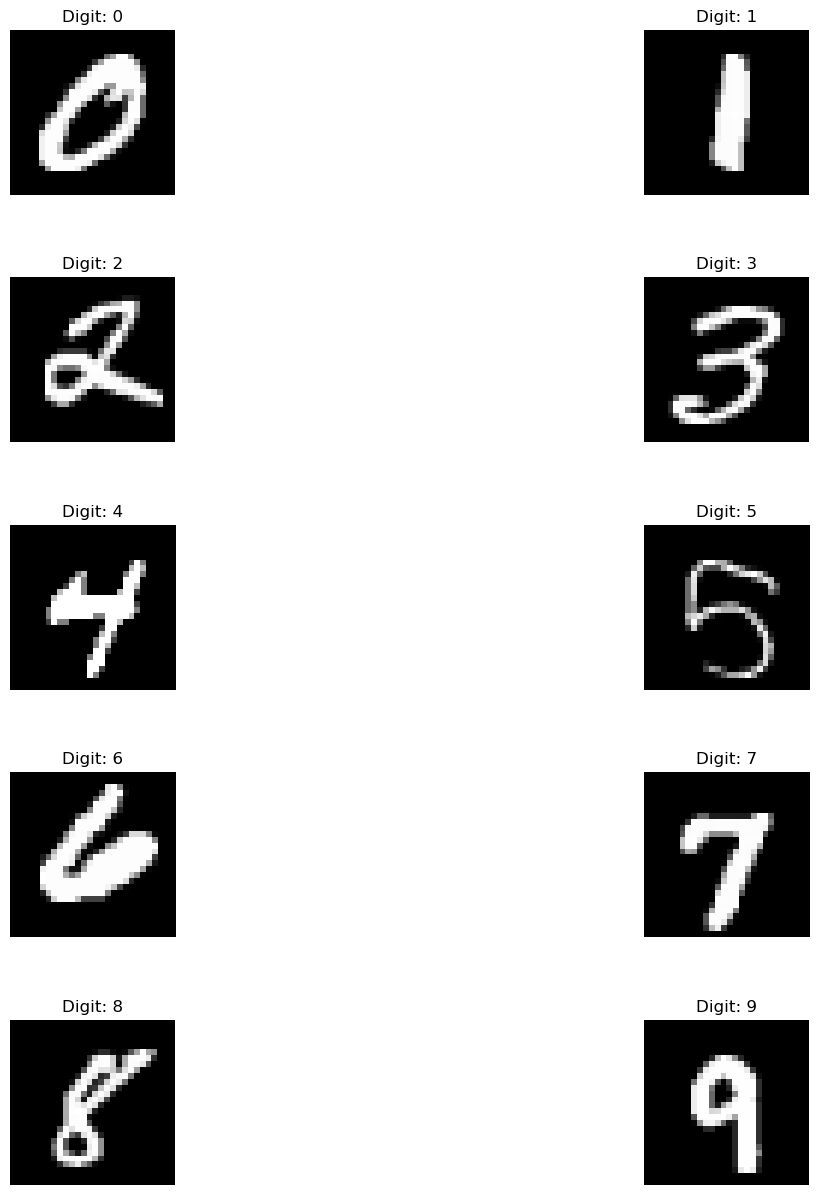

In [8]:
f = plt.figure(figsize = (15, 15))
count = 1
for i in range(0, 10):
  plt.gray()
  plt.subplot(5, 2, count)
  count = count + 1
  plt.subplots_adjust(hspace = 0.5)
  plt.title('Digit: ' + str(i))
  some_digit_image = labels_overview[:, i]
  plt.imshow(some_digit_image.reshape(28, 28))
  plt.axis('off')
  pass

## Adding Noise to the Dataset

We know add a source of noise to the MNIST images (by means of `np.random.normal` function), since our objective will be to remove the same noise from them.

In [9]:
noise_factor = 0.55
pure = input_train
pure_test = input_test
noise = np.random.normal(0, 1, pure.shape)
noise_test = np.random.normal(0, 1, pure_test.shape)
noisy_input = pure + noise_factor * noise
noisy_input_test = pure_test + noise_factor * noise_test

Now, let's plot some examples of images corrupted by noise (one for each class, as in the figure above).

In [10]:
# The following line is needed to reshape the training dataset 
# (to plot some image examples)
input_example_noise = noisy_input.reshape(60000, 784)

In [11]:
# The following code create a numpy array where in column 0 you will find 
# an example of label 0, in column 1 of label 1 and so on.
labels_overview = np.empty([784, 10])
for i in range (0, 10):
    col = get_random_element_with_label(input_example_noise, target_train, i)
    labels_overview[:,i] = col

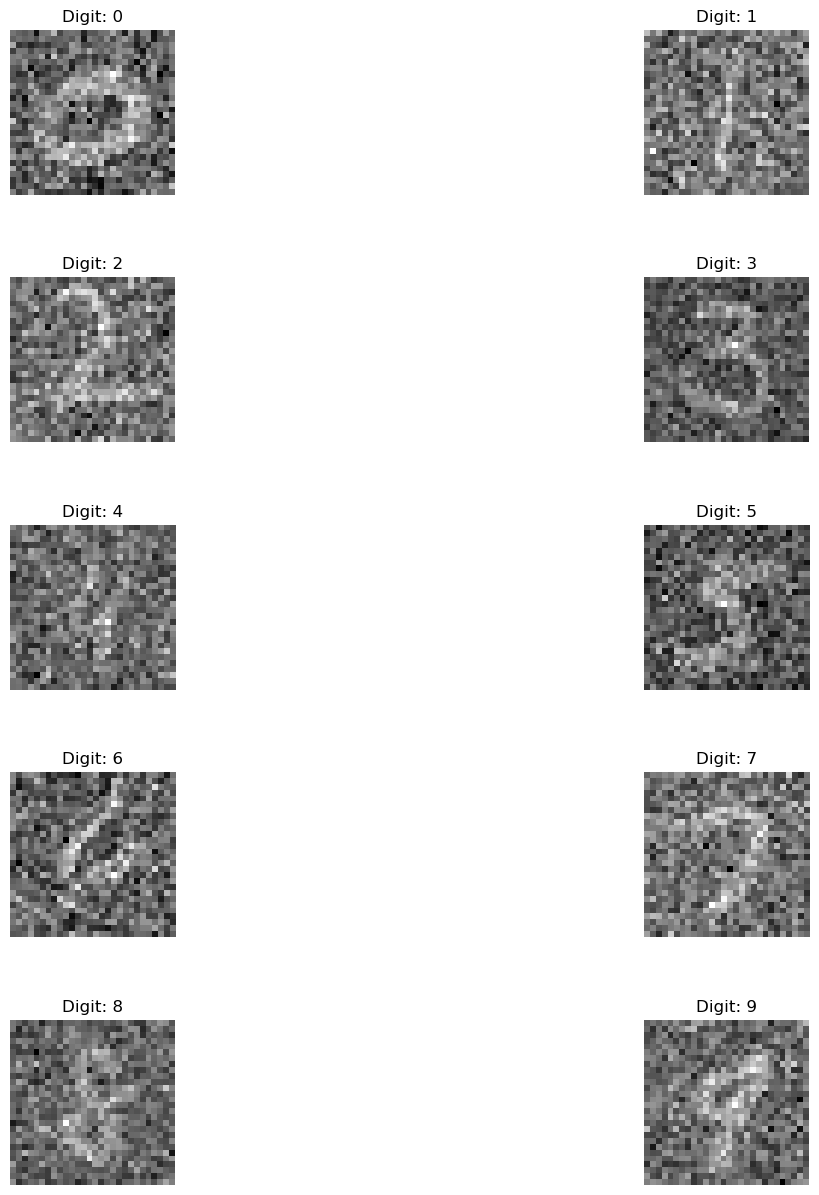

In [12]:
f = plt.figure(figsize = (15, 15))
count = 1
for i in range(0, 10):
  plt.gray()
  plt.subplot(5, 2, count)
  count = count + 1
  plt.subplots_adjust(hspace = 0.5)
  plt.title('Digit: ' + str(i))
  some_digit_image = labels_overview[:, i]
  plt.imshow(some_digit_image.reshape(28, 28))
  plt.axis('off')
  pass

## Autoencoder with Feed-Forward Neural Networks

Now we need to create the ```keras``` models. An autoencoder is made of two main parts: an _encoder_ and a _decoder_. The function below ```create_autoencoders()``` returns the following parts as separate models:

- the encoder 
- the decoder
- the complete model, when the encoder and decoder are joined in one model.

In [13]:
def create_autoencoders(feature_layer_dim = 16):

  input_img = Input(shape = (784,), name = 'Input_Layer')
  # 784 is the total number of pixels of MNIST images
  
  # The layer encoded has a dimension equal to feature_layer_dim and contains
  # the encoded input (therefore the name)
  encoded = Dense(feature_layer_dim, activation = 'relu', name = 'Encoded_Features')(input_img)
  decoded = Dense(784, activation = 'sigmoid', name = 'Decoded_Input')(encoded)

  autoencoder = Model(input_img, decoded)
  encoder = Model(input_img, encoded)

  encoded_input = Input(shape = (feature_layer_dim,))
  decoder = autoencoder.layers[-1]
  decoder = Model(encoded_input, decoder(encoded_input))

  return autoencoder, encoder, decoder

In [14]:
# 32 is the number of latent features of our autoencoder
autoencoder, encoder, decoder = create_autoencoders(64) 

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2024-04-16 15:22:30.670639: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-16 15:22:30.670826: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 784)]             0         
                                                                 
 Encoded_Features (Dense)    (None, 64)                50240     
                                                                 
 Decoded_Input (Dense)       (None, 784)               50960     
                                                                 
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________


As for any Keras model we need to compile the model and then fit it to the data. As you can see we don't need any custom code to work with autoencoders. A simple model **definition** $\rightarrow$ **compile** $\rightarrow$ **fit** is enough.

In [16]:
# Model configuration
batch_size = 150
no_epochs = 30
validation_split = 0.2

In [17]:
# Compile and fit data
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')
autoencoder.fit(noisy_input, pure,
                epochs = no_epochs,
                batch_size = batch_size,
                validation_split = validation_split)

Epoch 1/30


2024-04-16 15:22:35.741391: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-16 15:22:35.865944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x150x1x784xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must

  1/320 [..............................] - ETA: 4:59 - loss: 0.7023

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x150x1x784xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x150x1x784xi1>'


179/320 [===============>..............] - ETA: 0s - loss: 0.2825

## Examples of Denoised Images

Now we plot some examples of denoised images, comparing them with the original pure images, to see how well the built autoencoder behaves.

In [50]:
# Generate denoised images
number_of_visualizations = 6
samples = noisy_input_test[:number_of_visualizations]
targets = target_test[:number_of_visualizations]
denoised_images = autoencoder.predict(samples)

<Figure size 432x288 with 0 Axes>

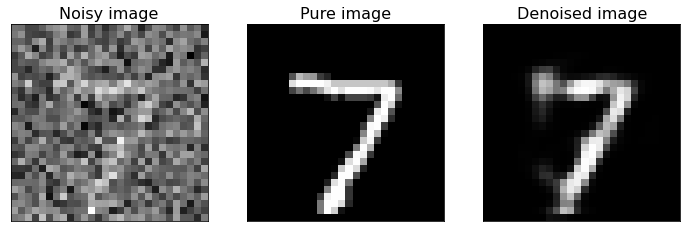

<Figure size 432x288 with 0 Axes>

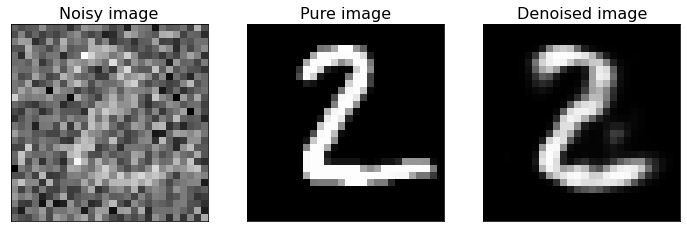

<Figure size 432x288 with 0 Axes>

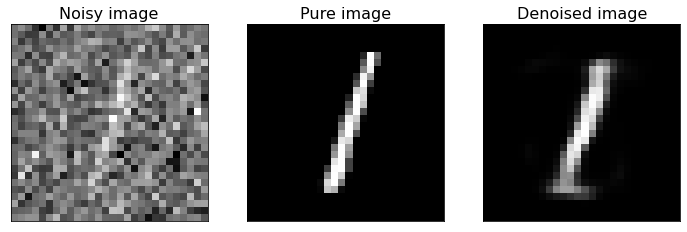

<Figure size 432x288 with 0 Axes>

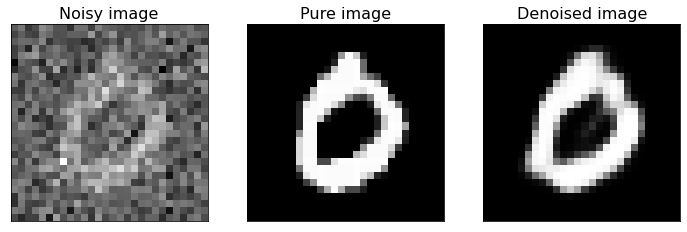

<Figure size 432x288 with 0 Axes>

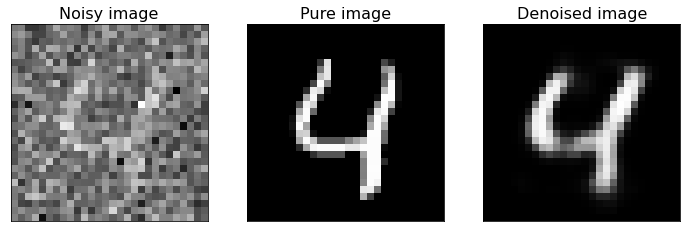

<Figure size 432x288 with 0 Axes>

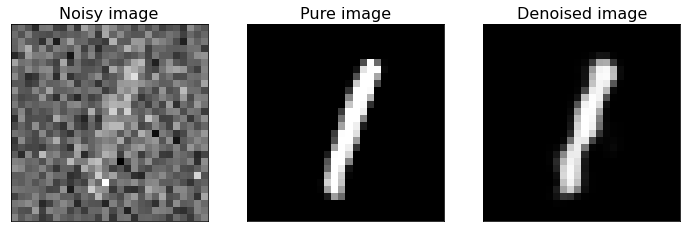

In [51]:
# Plot denoised images
for i in range(0, number_of_visualizations):
  plt.gray()
  # Get the sample and the reconstruction
  noisy_image = noisy_input_test[i].reshape(28, 28)
  pure_image  = pure_test[i].reshape(28, 28)
  denoised_image = denoised_images[i].reshape(28, 28)
  input_class = targets[i]
  # Matplotlib preparations
  fig, axes = plt.subplots(1, 3)
  fig.set_size_inches(12, 7)
  # Plot sample and reconstruciton
  axes[0].imshow(noisy_image)
  axes[0].set_title('Noisy image', fontsize = 16)
  axes[0].get_xaxis().set_visible(False)
  axes[0].get_yaxis().set_visible(False)
  axes[1].imshow(pure_image)
  axes[1].set_title('Pure image', fontsize = 16)
  axes[1].get_xaxis().set_visible(False)
  axes[1].get_yaxis().set_visible(False)
  axes[2].imshow(denoised_image)
  axes[2].set_title('Denoised image', fontsize = 16)
  axes[2].get_xaxis().set_visible(False)
  axes[2].get_yaxis().set_visible(False)
  plt.show()

As you can see from the above figure, the model we built can reconstruct the original version of noisy digit images. If you have new noisy images of the same type you can apply the model to them and de-noise the same images.

If you compare this last figure with the last figure of Denoising_autoencoders_with_CNN.ipynb notebook, you can notice that CNNs are better suited to this kind of task. In fact, they are specifically designed for working with images, more than FFNNs.